In [1]:
from typing import Any, Optional, Iterable, Callable, Literal, SupportsFloat, SupportsInt
from numpy.typing import NDArray
from torch.types import Tensor, Device

from pathlib import Path

import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tensordict import TensorDict

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

import math
from functools import partial

from cpscheduler.environment import SchedulingCPEnv, Env, AsyncVectorEnv, VectorEnv, SyncVectorEnv, RayVectorEnv
from cpscheduler.environment.instances import generate_taillard_instance, read_jsp_instance
from cpscheduler.environment.wrappers import WrappedEnv
from cpscheduler.environment.utils import AVAILABLE_SOLVERS, is_iterable_type, convert_to_list
from cpscheduler.algorithms import BaseAlgorithm, Buffer, Logs
from cpscheduler.common_envs import JobShopEnv

root = Path().absolute().parent

## An End-to-End Reinforcement Learning Approach for Job-Shop Scheduling Problems Based on Constraint Programming

This notebook is a implementation of the paper _An End-to-End Reinforcement Learning Approach for Job-Shop Scheduling Problems Based on Constraint Programming_, which introduces a scheme for training schedulers for Job-shop instances with different sizes, relying on a Constraint-Programming algorithm to provide the current state of the environment (This idea is brought into this repository to calculate the earliest possible times for future tasks, not for the state itself.).

## Introduction
The **Job-Shop Scheduling Problem (JSSP)** is a well-known combinatorial optimization challenge where a set of jobs, each consisting of ordered operations, must be scheduled on available machines while minimizing an objective like the makespan or total tardiness. This problem is ubiquitous in industries like manufacturing, logistics, and healthcare, yet solving large-scale instances is computationally challenging due to their NP-hard nature.

Traditional Constraint Programming (CP) provides a compact and declarative way to model such problems. While CP solvers are efficient for small instances, they struggle with scaling, necessitating faster heuristic solutions in real-world settings. Priority Dispatching Rules (PDRs), common in these scenarios, are limited by their handcrafted nature and inconsistent performance.

In recent years, Reinforcement Learning (RL) has emerged as a powerful tool for learning policies to solve optimization problems. Existing RL approaches for JSSP often depend on custom simulations, handcrafted reward functions, and heavy feature engineering, limiting their generality and scalability.

### State Space
The state space of the paper is very different from the ones usually employed in RL approaches for JSP. The operations graph is not considered, instead, the interval variables of tasks within an operation range, for each job, are considered, given a set of jobs and the operations $o_{ij}$ put into the state are, for each job,
- Previous operation: The last completed operation of the job.
- Current operation: The operation currently scheduled (not finished)
- Next operations: A fixed number of upcoming operations

Each operation is represented as a 4-tuple regarding the operation state in current environment, including
- Fixed: Boolean indicating whether the task is fixed or not.
- Start Lower bound: The lower bound for the start time of the task.
- Processing time: The processing time of the task.
- Available: Boolean indicating whether the task is available or not.

In [2]:
def build_state(
        obs: NDArray[np.void],
        env: SchedulingCPEnv,
        n_future_tasks: int = 3
    ) -> Tensor:
    jobs = np.unique(obs['job'])

    is_fixed    = np.array(env.tasks.is_fixed())
    lower_bound = np.array(env.tasks.get_start_lb())

    order = np.argsort(obs, order=['job', 'operation'])

    obs         = obs[order]
    is_fixed    = is_fixed[order]
    lower_bound = lower_bound[order]

    state      = np.zeros((len(jobs), 2+n_future_tasks, 6), dtype=np.int32)

    for i, job in enumerate(jobs):
        job_obs = obs[obs['job'] == job]

        last_finished = np.max(job_obs['operation'][job_obs['buffer'] == 'finished'], initial=-1)
        n_jobs = len(job_obs)

        job_ops = [op if (0 <= op < n_jobs) else -1 for op in range(last_finished, last_finished+n_future_tasks+2)]

        job_mask = np.array(job_ops) != -1

        # Kinda smelly code
        state[i, job_mask, 0] = is_fixed[obs['job'] == job][job_ops][job_mask]
        state[i, job_mask, 1] = lower_bound[obs['job'] == job][job_ops][job_mask]
        state[i, job_mask, 2] = job_obs[job_ops]['processing_time'][job_mask]
        state[i, job_mask, 3] = (job_obs[job_ops]['buffer'] == 'available')[job_mask]
        state[i, job_mask, 4] = job_obs[job_ops]['machine'][job_mask]
        state[i, :, 5] = job_ops

    return torch.from_numpy(state)


class End2EndEnv(WrappedEnv):
    instance_: list[list[int]]
    jobs: list[int]

    def __init__(
            self,
            env: SchedulingCPEnv,
            n_jobs: int,
            n_future_tasks: int = 3
        ):
        super().__init__(env)

        self.env = env

        self.n_jobs = n_jobs
        self.n_future_tasks = n_future_tasks

        self.instance_   = [[] for _ in range(self.n_jobs)]
        self.current_ops = [ 0 for _ in range(self.n_jobs)]


    def process_instance(self, obs: dict[str, list[Any]]) -> None:
        obs = self.env._get_obs()
        self.jobs = obs['job']

        for i in range(self.n_jobs):
            self.current_ops[i] = 0

        # We suppose that the tasks are ordered by operation
        task: int
        for task in obs['task_id']:
            operation: int = obs['operation'][task]
            job: int       = obs['job'][task]

            if operation >= len(self.instance_[job]):
                self.instance_[job].extend([-1 for _ in range(operation - len(self.instance_[job]) + 1)])

            self.instance_[job][operation] = task

            if obs['buffer'][task] == 'finished' or obs['buffer'][task] == 'executing':
                self.current_ops[job] = operation + 1


    def reset(self) -> tuple[Tensor, dict[str, Any]]:
        obs, info = self.env.reset()
        self.process_instance(obs)

        obs = np.array(
            list(zip(*obs.values())),
            dtype=[
                ('task_id', np.int32),
                ('job', np.int32),
                ('operation', np.int32),
                ('machine', np.int32),
                ('processing_time', np.int32),
                ('remaining_time', np.int32),
                ('buffer', 'U9')
            ]
        )

        new_obs = build_state(obs, self.env, self.n_future_tasks)

        return new_obs, info


    def step(self, action: SupportsInt | Iterable[SupportsInt]) -> tuple[Tensor, SupportsFloat, bool, bool, dict[str, Any]]:
        if is_iterable_type(action, SupportsInt):
            parsed_action = convert_to_list(action, int)

        else:
            assert isinstance(action, SupportsInt)
            parsed_action = [int(action)] if int(action) < self.n_jobs else None


        processed_action: Optional[list[int]]
        if parsed_action is None:
            processed_action = None

        else:
            processed_action = []
            for job_idx in parsed_action:
                if job_idx >= self.n_jobs:
                    continue

                idx = self.current_ops[job_idx]

                processed_action.append(self.instance_[job_idx][idx])

                self.current_ops[job_idx] += 1


        obs, reward, terminated, truncated, info = self.env.step(processed_action)

        obs = np.array(
            list(zip(*obs.values())),
            dtype=[
                ('task_id', np.int32),
                ('job', np.int32),
                ('operation', np.int32),
                ('machine', np.int32),
                ('processing_time', np.int32),
                ('remaining_time', np.int32),
                ('buffer', 'U9')
            ]
        )

        new_obs = build_state(obs, self.env, self.n_future_tasks)
        return new_obs, reward, terminated, truncated, info


    def get_cp_solution(
            self,
            timelimit: Optional[float] = None,
            solver: AVAILABLE_SOLVERS = 'cplex'
        ) -> tuple[list[int], list[int], SupportsFloat, bool]:

        task_order, start_times, objective_values, is_optimal = self.env.get_cp_solution(timelimit, solver)

        parsed_starts = [start_times[task] for task in task_order]
        action        = [self.jobs[idx] for idx in task_order]

        return action, parsed_starts, objective_values, is_optimal


def make_env(
        n_jobs: int,
        n_machines: int,
        n_future_tasks: int = 3
    ) -> Callable[[], End2EndEnv]:
    def env_fn() -> End2EndEnv:
        instance, metadata = generate_taillard_instance(n_jobs, n_machines)

        env = JobShopEnv(instance)
        env = End2EndEnv(env, metadata['n_jobs'], n_future_tasks)

        return env

    return env_fn


def make_eval_env(
        i: int,
        n_future_tasks: int = 3
    ) -> Callable[[], End2EndEnv]:
    def env_fn() -> End2EndEnv:
        instance, metadata = read_jsp_instance(root / f'instances/jobshop/ta{i:02d}.txt')

        env = JobShopEnv(instance)
        env = End2EndEnv(env, metadata['n_jobs'], n_future_tasks)

        return env

    return env_fn

### Network Architecture

The policy used is a 2-stage Transformer that takes the state defined above into the probability of choosen a given job to schedule its operation, or do noting (NO-OP). The first stage is used to learn a representation for the inverval variables, the attention is done between tasks within the same job. The representations are then passed to the second stage, where another transformer takes cross-job information to decide which job to allocate or to do nothing.

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        self.pe = pe

    def forward(self, positions: Tensor) -> Tensor:
        return self.pe[positions]


def layer_init(layer: nn.Module, gain: int = 1, bias_const=0.0) -> nn.Module:
    torch.nn.init.orthogonal_(layer.weight, gain)

    if hasattr(layer, "bias") and layer.bias is not None:
        torch.nn.init.constant_(layer.bias, bias_const)
    
    return layer


class End2EndActor(nn.Module):
    def __init__(
            self,
            d_model: int,
            n_heads: int = 1,
            n_layers: int = 1,
            dropout: float = 0.
        ):
        super().__init__()

        self.d_model = d_model

        self.embedding_fixed = nn.Embedding(2, 1)
        self.embedding_legal_op = nn.Embedding(2, 1)

        self.obs_projection = nn.Linear(4, d_model)
        layer_init(self.obs_projection)        

        self.pos_encoder = PositionalEncoding(d_model)

        transformer_encoder = nn.TransformerEncoderLayer(
            d_model, n_heads, dim_feedforward=4*d_model, dropout=dropout, batch_first=True, norm_first=True
        )

        action_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, dim_feedforward=4*d_model, dropout=dropout, batch_first=True, norm_first=True
        )

        self.job_encoder = nn.TransformerEncoder(
            transformer_encoder,
            n_layers,
            enable_nested_tensor=False
        )

        self.action_transformer = nn.TransformerEncoder(
            action_layer,
            n_layers,
            enable_nested_tensor=False
        )

        self.jobs_action = nn.Sequential(
            layer_init(nn.Linear(d_model, out_features=4*d_model)),
            nn.Tanh(),
            layer_init(nn.Linear(4*d_model, 1))
        )

        # self.no_op_action = nn.Sequential(
        #     layer_init(nn.Linear(d_model, 4*d_model)),
        #     nn.Tanh(),
        #     layer_init(nn.Linear(4*d_model, 1))
        # )


    def forward(self, obs: Tensor):
        embedded_obs = torch.cat((
            self.embedding_fixed(obs[:, :, :, 0].long()),
            obs[:, :, :, 1:3],
            self.embedding_legal_op(obs[:, :, :, 3].long())),
        dim=3)

        batch_size, n_jobs, n_ops, n_features = embedded_obs.shape

        pos_encoding = self.pos_encoder(obs[:, :, :, -1].long())
        proj_obs = self.obs_projection(embedded_obs) + pos_encoding

        input_mask = obs[:, :, :, -1] == -1

        encoded_jobs = self.job_encoder(
            proj_obs.view(-1, n_ops, self.d_model),
            src_key_padding_mask=input_mask.view(-1, n_ops)
        ).view(batch_size, n_jobs, n_ops, self.d_model)

        encoded_jobs = encoded_jobs.mean(dim=2)

        machines     = obs[:, :, 1, 4]
        finished_job = input_mask[:, :, 1]

        job_resource_mask = ~(machines.unsqueeze(1) == machines.unsqueeze(-1))

        encodings = self.action_transformer(encoded_jobs, src_key_padding_mask=finished_job, mask=job_resource_mask)

        job_final = self.jobs_action(encodings)
        # no_op     = self.no_op_action(encodings)

        # logits = torch.cat((job_final.squeeze(2), no_op.mean(dim=1)), dim=1)

        # available_jobs = obs[:, :, 1, 3].bool()

        # no_op_mask = torch.ones(batch_size, 1, dtype=torch.bool, device=obs.device)
        # mask = torch.cat((available_jobs, no_op_mask), dim=1)

        # logits = torch.masked_fill(logits, ~mask, -torch.inf)

        logits = job_final.squeeze(2)

        mask = torch.logical_or(
            finished_job,
            torch.logical_and(
                input_mask[:, :, 2],
                obs[:, :, 1, 0].bool()
            )
        )

        logits = torch.masked_fill(logits, mask, -torch.inf)

        return logits

In [1]:
def mark(fn: Callable) -> Callable:
    setattr(fn, '__mark__', True)
    return fn

class Something:
    def __init__(self) -> None:
        
        self.maked_fns = [

        ]
    
    @mark
    def something(self):
        pass

In [4]:
class End2End(BaseAlgorithm):
    def __init__(
        self,
        agent: nn.Module,
        optimizer: optim.Optimizer,
        device: Device = "cuda",
        n_envs: int = 128,
        n_jobs: int = 10,
        n_machines: int = 10,
        vector_env: Literal["async", "sync", "ray"] = "async",
        *,
        n_future_tasks: int = 3,
        clip_coef: float = 0.3,
        reward_norm: bool = True,
        anneal_lr: bool = True,
        time_limit: Optional[int] = 30,
    ):
        buffer_shapes = {
            "obs": (n_jobs, 2 + n_future_tasks, 6),
            "action": (),
            "log_prob": (),
            "improvement": (),
            "returns": (),
        }

        capacity = 2 * n_envs * n_jobs * n_machines
        buffer = Buffer(capacity, buffer_shapes, device)

        super().__init__(buffer)

        self.agent = agent
        self.optimizer = optimizer

        self.n_future_tasks = n_future_tasks
        self.clip_coef      = clip_coef
        self.reward_norm    = reward_norm
        self.anneal_lr      = anneal_lr

        self.n_jobs     = n_jobs
        self.n_machines = n_machines
        self.env_fn = make_env(n_jobs, n_machines, n_future_tasks)

        self.n_envs = n_envs
        self.vector_env = vector_env

        self.time_limit = time_limit


    def on_session_start(
        self, num_updates: int, steps_per_update: int, batch_size: int
    ):
        if self.anneal_lr:
            self.lr_delta = self.optimizer.param_groups[0]["lr"] / num_updates


    def on_epoch_start(self) -> Logs:
        self.agent.eval()
        self.buffer.clear()

        if self.vector_env == "async":
            envs = AsyncVectorEnv(
                [self.env_fn for _ in range(self.n_envs)], auto_reset=False
            )

        elif self.vector_env == "sync":
            envs = SyncVectorEnv(
                [self.env_fn for _ in range(self.n_envs)], auto_reset=False
            )

        else:
            envs = RayVectorEnv(
                [self.env_fn for _ in range(self.n_envs)], auto_reset=False
            )

        horizon = self.n_jobs * self.n_machines

        obs, info = envs.reset()

        observations = torch.empty(
            (self.n_envs, horizon, *self.buffer.buffer_shapes["obs"]),
            dtype=torch.float32,
        )
        actions = torch.empty(
            (self.n_envs, horizon, *self.buffer.buffer_shapes["action"]),
            dtype=torch.int64,
        )
        log_probs = torch.empty(
            (self.n_envs, horizon, *self.buffer.buffer_shapes["log_prob"]),
            dtype=torch.float32,
        )

        for i in range(horizon):
            tensor_obs = torch.stack(obs).to(self.device)
            observations[:, i] = tensor_obs

            with torch.no_grad():
                logits = self.agent(tensor_obs).cpu()

            categorical = torch.distributions.Categorical(logits=logits)

            action   = categorical.sample()
            log_prob = categorical.log_prob(action)

            actions[:, i]   = action
            log_probs[:, i] = log_prob

            obs, reward, terminated, truncated, info = envs.step(action)


        agent_return = torch.tensor(info["objective_value"], dtype=torch.float32)

        # Calculate partial solution with the cp solver to calculate improvement
        sampled_idx = random.randint(1, horizon-1)

        logged_actions = actions[:, :sampled_idx]

        envs.reset()

        obs, reward, terminated, truncated, info = envs.step(logged_actions)
        cp_actions, cp_start_time, cp_makespan, is_optimal = envs.call("get_cp_solution", timelimit=self.time_limit)

        cp_return = torch.tensor(cp_makespan, dtype=torch.float32)

        improvement = 1 - cp_return / agent_return
        return_ = cp_return.repeat(horizon, 1).T
        return_[:, sampled_idx:] = agent_return

        self.buffer.add(
            obs         = observations,
            action      = actions,
            log_prob    = log_probs,
            improvement = -improvement.repeat(horizon, 1).T,
            returns     = return_,
        )

        new_horizon = horizon - sampled_idx
        for i in range(new_horizon):
            tensor_obs = torch.stack(obs).to(self.device)
            observations[:, i] = tensor_obs

            with torch.no_grad():
                logits = self.agent(tensor_obs).cpu()

            categorical = torch.distributions.Categorical(logits=logits)

            action = torch.tensor([
                cp_actions[job][i] for job in range(self.n_envs)
            ])

            log_prob = categorical.log_prob(action)

            assert torch.isfinite(log_prob).all()

            actions[:, i]   = action
            log_probs[:, i] = log_prob

            obs, reward, terminated, truncated, info = envs.step(action.cpu())

        self.buffer.add(
            obs         = observations[:, :new_horizon],
            action      = actions[:, :new_horizon],
            log_prob    = log_probs[:, :new_horizon],
            improvement = improvement.repeat(new_horizon, 1).T,
            returns     = cp_return.repeat(new_horizon, 1).T,
        )

        if self.reward_norm:
            self.buffer.normalize("returns", kind='standard')
            self.buffer.normalize("improvement")

        envs.close()

        return Logs({
            "objective": agent_return.tolist(),
        })


    def update(self, batch: TensorDict) -> dict[str, Any]:
        logits = self.agent(batch["obs"])

        log_prob = torch.distributions.Categorical(logits=logits).log_prob(
            batch["action"]
        )

        log_ratio = log_prob - batch["log_prob"]
        ratio = torch.exp(log_ratio)

        with torch.no_grad():
            # calculate approx_kl http://joschu.net/blog/kl-approx.html
            approx_kl = torch.mean((ratio - 1) - log_ratio)

        returns = batch["returns"]

        if approx_kl > 1000:
            raise ValueError(f"approx_kl is too high: {approx_kl}")

        pg_loss1 = - returns * ratio
        pg_loss2 = - returns * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef)
        pg_loss = torch.max(pg_loss1, pg_loss2).mean()

        pg_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return {
            "loss": pg_loss.item(),
            "approx_kl": approx_kl.item(),
        }

    def on_epoch_end(self) -> dict[str, Any]:
        epoch_lr = self.optimizer.param_groups[0]["lr"]

        if self.anneal_lr:
            self.optimizer.param_groups[0]["lr"] = max(epoch_lr - self.lr_delta, 1e-6)

        return {"learning rate": epoch_lr}


    def validate(self) -> dict[str, Any] | Logs:
        makespans = list(map(
            int,
            [
                read_jsp_instance(root / f"instances/jobshop/ta{i:02d}.txt")[1]["Makespan UB"]
                for i in range(1, 81)
            ],
        ))

        val_makespans = []

        for group in range(8):
            initial = group * 10 + 1
            taillard_envs = AsyncVectorEnv(
                [make_eval_env(i) for i in range(initial, initial + 10)],
                auto_reset=False,
            )

            obs, info = taillard_envs.reset()
            running = [True] * 10
            while any(running):
                tensor_obs, tensor_mask = obs

                with torch.no_grad():
                    logits = self.agent(tensor_obs, tensor_mask)
                    action = torch.argmax(logits, dim=1)

                obs, reward, terminated, truncated, info = taillard_envs.step(
                    action.cpu().numpy()
                )

                running = [not done for done in terminated]

            val_makespans.extend(info["objective_value"])

        return Logs({
            "optimality gap": [
                (val - optimal) / optimal
                for val, optimal in zip(val_makespans, makespans)
            ]
        })

In [5]:
d_model = 8
n_future_tasks = 3
time_limit = 30

device = 'cuda:1'
seed: int = 42

# Training parameters
n_envs: int = 128
vector_env: Literal['async', 'sync', 'ray'] = 'async'

learning_rate : float           = 2.5e-4
batch_size    : int             = 128
clip_coef     : float           = 0.2
update_epochs : int             = 16
n_updates     : int             = 100
target_kl     : Optional[float] = 0.01
anneal_lr     : bool            = True
reward_norm   : bool            = True

if seed is not None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

agent = End2EndActor(d_model).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

In [6]:
algo = End2End(
    agent,
    optimizer,
    n_future_tasks = n_future_tasks,
    device         = device,
    n_envs         = n_envs,
    vector_env     = vector_env,
    clip_coef      = clip_coef,
    reward_norm    = reward_norm,
    anneal_lr      = anneal_lr,
)

In [7]:
algo.begin_experiment(
    'end2end-makespan',
    '10x10',
    root / 'logs',
    use_wandb=False,
)

algo.learn(
    n_updates,
    update_epochs,
    batch_size,
    validation_freq=None
)

Epoch 1/100: : 1904 steps [00:30, 62.17 steps/s, start/objective=2228.5625 ± 214.5756, update/loss=-0.3317 ± 0.0173, update/approx_kl=0.0012 ± 0.0008, end/learning rate=0.0003]
Epoch 2/100: : 2976 steps [00:48, 61.14 steps/s, start/objective=2215.5781 ± 193.1351, update/loss=-0.4773 ± 0.0397, update/approx_kl=0.0081 ± 0.0015, end/learning rate=0.0002]
Epoch 3/100: : 3152 steps [00:53, 58.60 steps/s, start/objective=2225.3516 ± 196.6172, update/loss=-0.5231 ± 0.0569, update/approx_kl=0.0100 ± 0.0100, end/learning rate=0.0002]
Epoch 4/100: : 1696 steps [00:30, 56.40 steps/s, start/objective=2014.0781 ± 195.4925, update/loss=-0.4449 ± 0.0105, update/approx_kl=0.0098 ± 0.0049, end/learning rate=0.0002]
Epoch 5/100: : 2640 steps [00:44, 59.05 steps/s, start/objective=2050.8516 ± 184.5571, update/loss=-0.4761 ± 0.0413, update/approx_kl=0.0322 ± 0.0097, end/learning rate=0.0002]
Epoch 6/100: : 2704 steps [00:45, 60.03 steps/s, start/objective=1827.9453 ± 183.3255, update/loss=-0.4846 ± 0.0413

ValueError: Normalization scale for key returns is zero. Does the data have constant values?

In [10]:
makespans = list(map(
    int,
    [
        read_jsp_instance(root / f"instances/jobshop/ta{i:02d}.txt")[1]["Makespan UB"]
        for i in range(1, 81)
    ],
))

In [13]:
val_makespans = []

for group in range(8):
    initial = group * 10 + 1
    taillard_envs = AsyncVectorEnv(
        [make_eval_env(i) for i in range(initial, initial + 10)],
        auto_reset=False,
    )

    obs, info = taillard_envs.reset()
    for _ in range(1000):
        tensor_obs = torch.stack(obs).to(device)

        with torch.no_grad():
            logits = agent(tensor_obs)
            action = torch.argmax(logits, dim=1)

        obs, reward, terminated, truncated, info = taillard_envs.step(
            action.cpu()
        )

        if all(terminated):
            break
    
    break

    val_makespans.extend(info["objective_value"])

In [15]:
info["objective_value"]

[1715, 1747, 1866, 1653, 1852, 1594, 1869, 1718, 1872, 1944]

Exception ignored in: Exception ignored in: Exception ignored in: <function AsyncVectorEnv.__del__ at 0x7fa1f36d8540><function AsyncVectorEnv.__del__ at 0x7fa1f36d8540>
Traceback (most recent call last):

  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 205, in __del__
Traceback (most recent call last):
    self.close()
  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 130, in close
<function AsyncVectorEnv.__del__ at 0x7fa1f36d8540>  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 205, in __del__

    Traceback (most recent call last):
    self.close()process.join()  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 205, in __del__


      File "/home/daniel.gratti/miniconda3/envs/scheduling/lib/python3.11/multiprocessing/process.py", line 147, in join
  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment

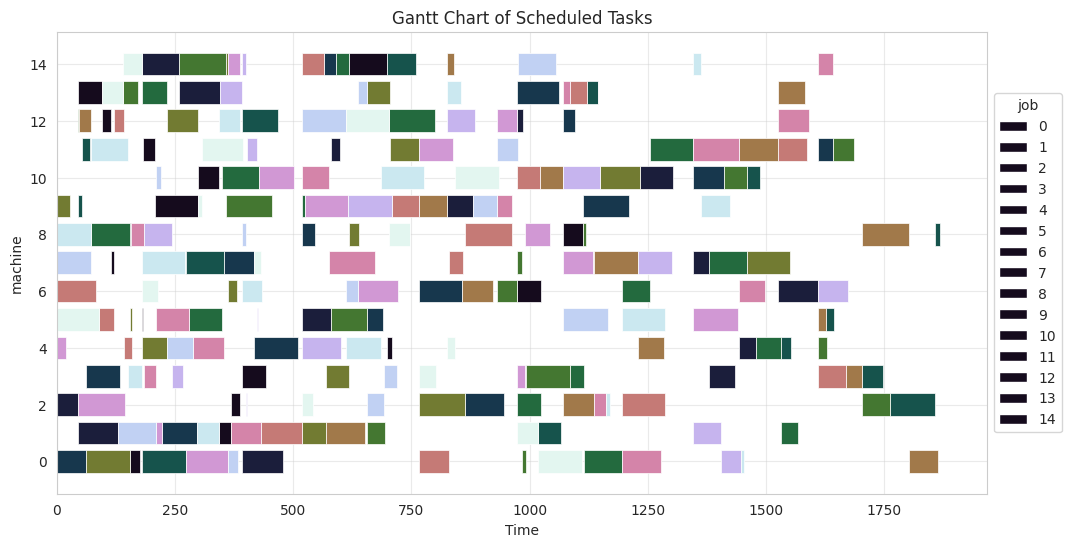

^  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 130, in close
^^ ^^     ^^^process.join() ^^^
 ^^^  File "/home/daniel.gratti/miniconda3/envs/scheduling/lib/python3.11/multiprocessing/process.py", line 147, in join
 ^^ ^^    ^ ^^assert self._parent_pid == os.getpid(), 'can only join a child process' 
^^
 ^^AssertionError  ^^:  ^^^can only join a child process ^^^
 ^^^^ ^^Exception ignored in: ^ ^
<function AsyncVectorEnv.__del__ at 0x7fa1f36d8540>^ ^AssertionError
^ ^: Traceback (most recent call last):
 ^^can only join a child process  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 205, in __del__
^ ^
^     ^^^self.close()Exception ignored in: ^^
^<function AsyncVectorEnv.__del__ at 0x7fa1f36d8540>^^  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 130, in close

^^^Traceback (most recent call last):
    ^^^  File "/work/daniel.gratti/scheduling-cp/cpsch

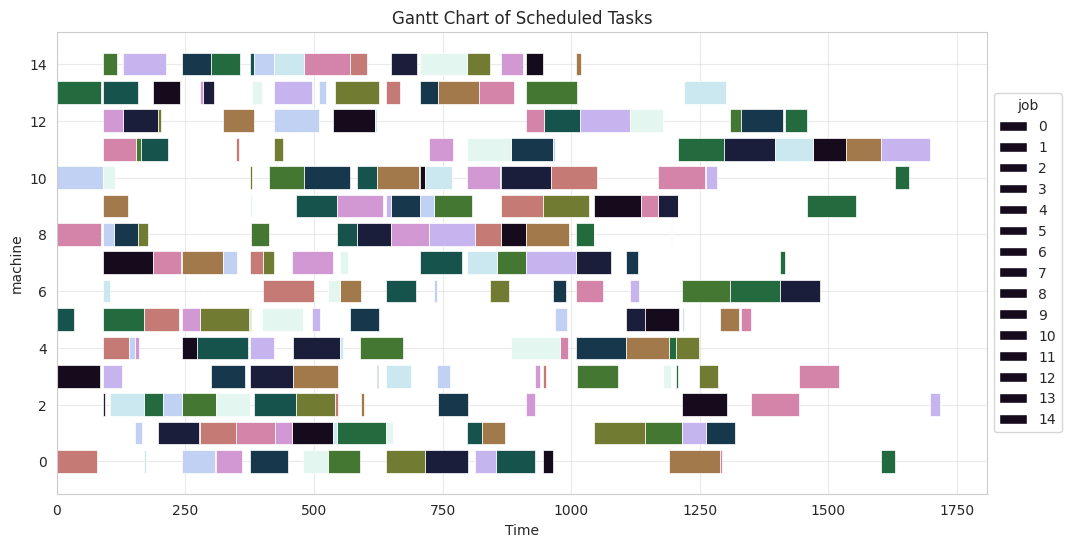

process.join()
  File "/home/daniel.gratti/miniconda3/envs/scheduling/lib/python3.11/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^

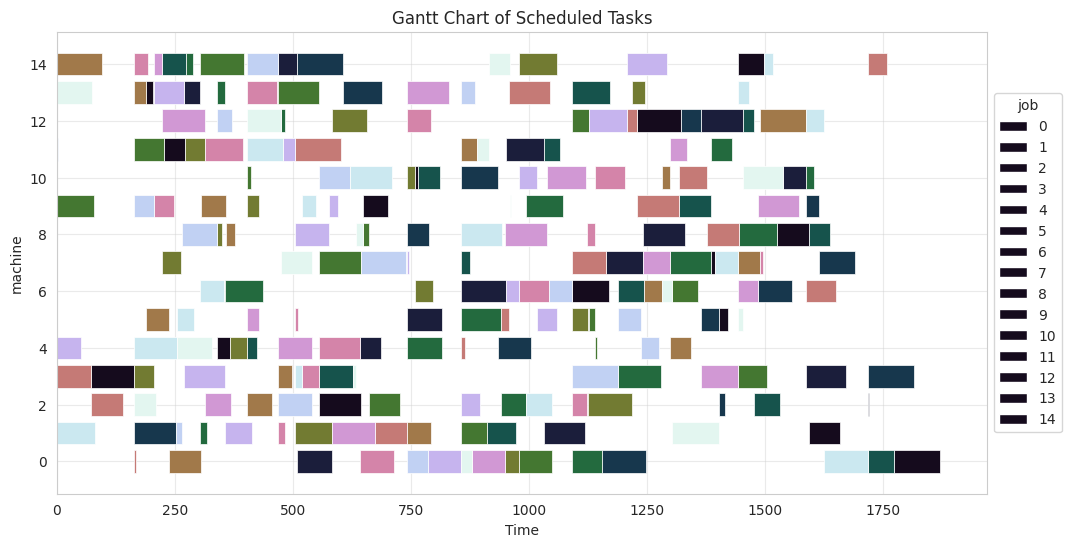

^^^^^^^
AssertionError: can only join a child process
Exception ignored in: <function AsyncVectorEnv.__del__ at 0x7fa1f36d8540>
Traceback (most recent call last):
  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 205, in __del__
    self.close()
  File "/work/daniel.gratti/scheduling-cp/cpscheduler/environment/vector/async_env.py", line 130, in close
    process.join()
  File "/home/daniel.gratti/miniconda3/envs/scheduling/lib/python3.11/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only join a child process


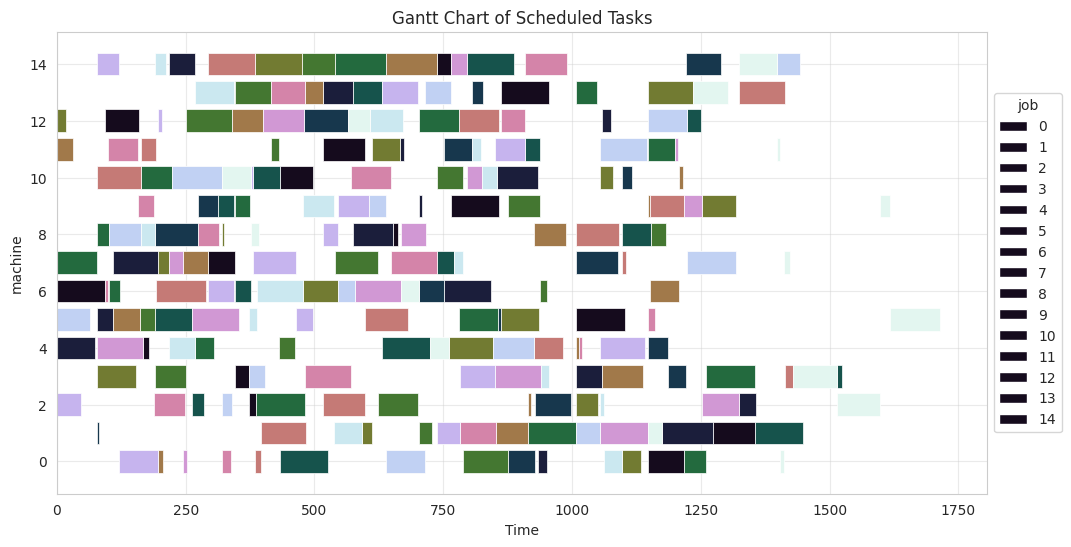

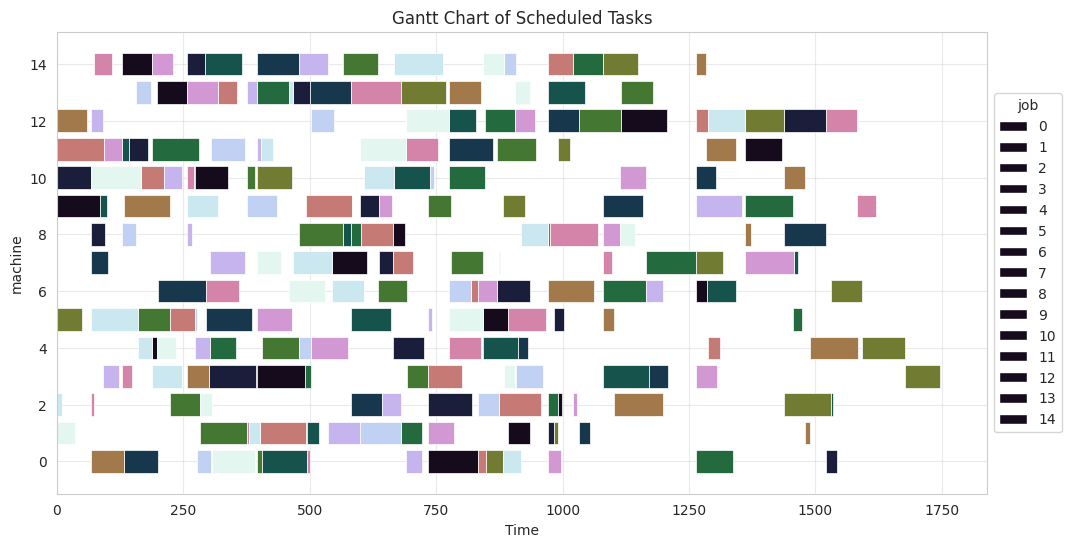

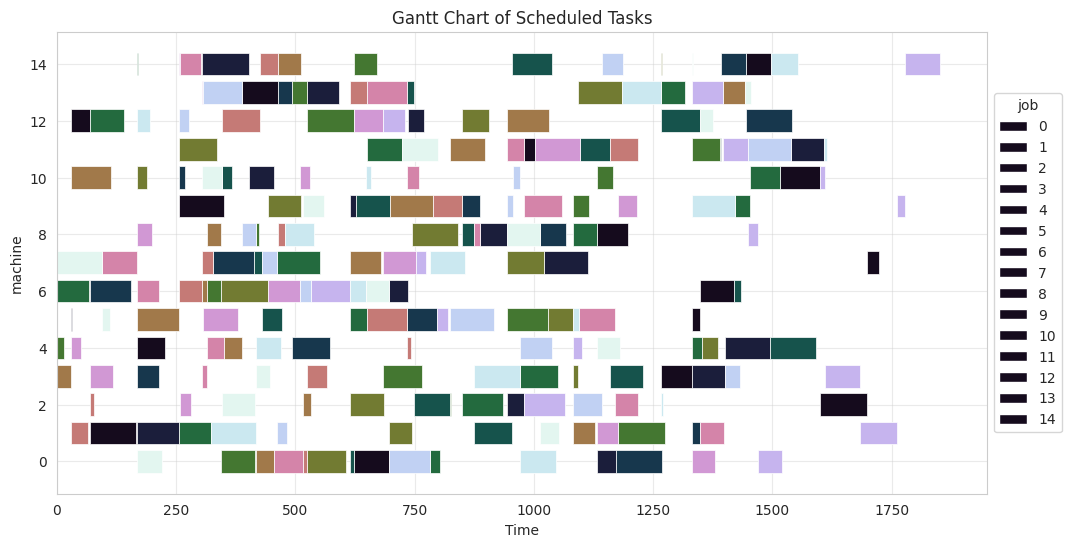

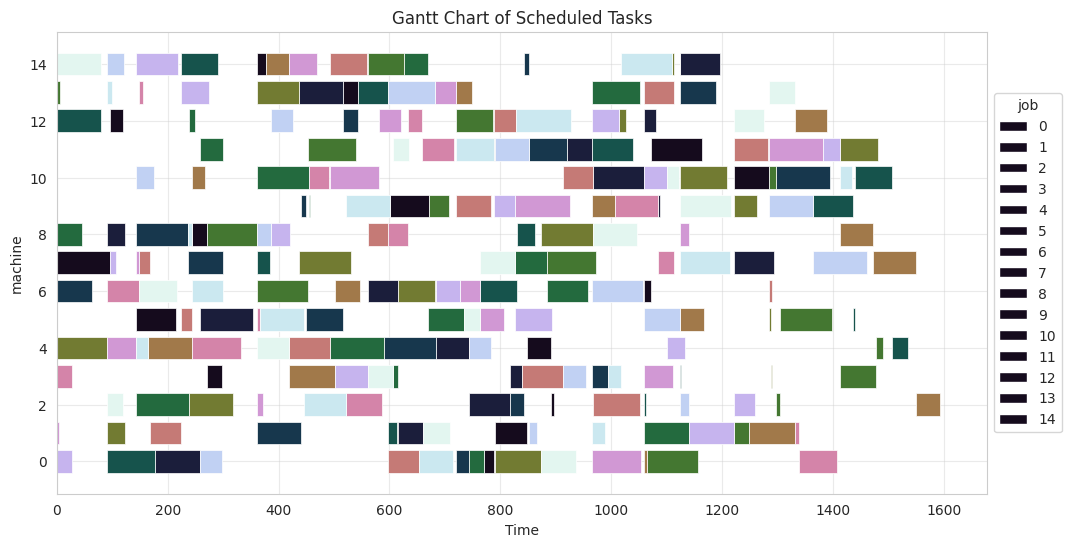

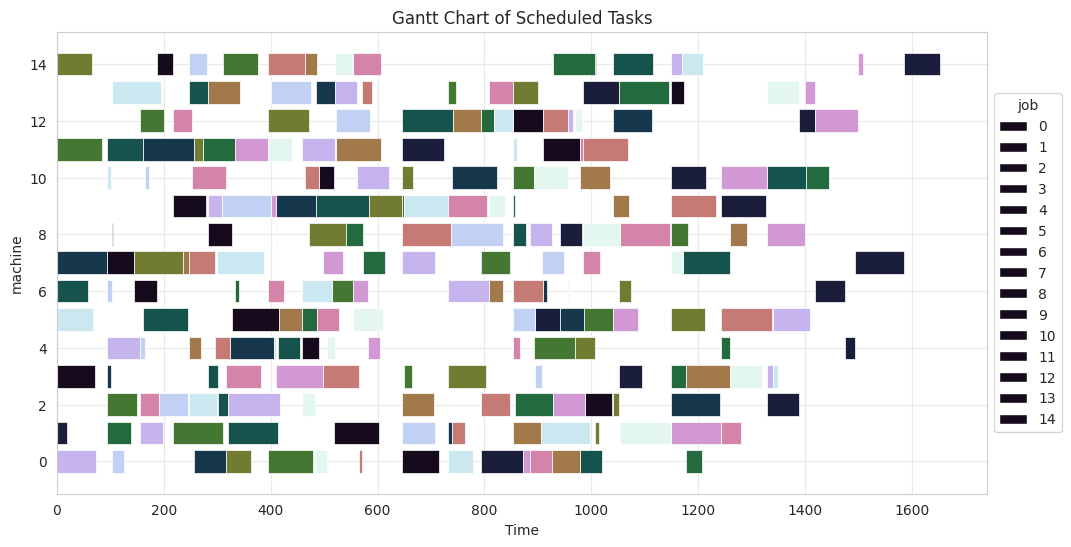

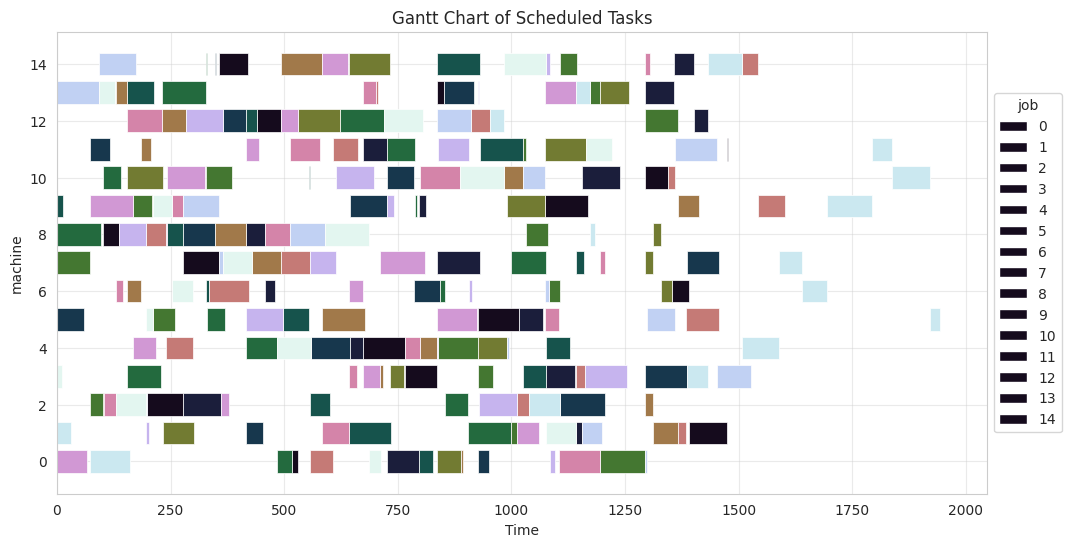

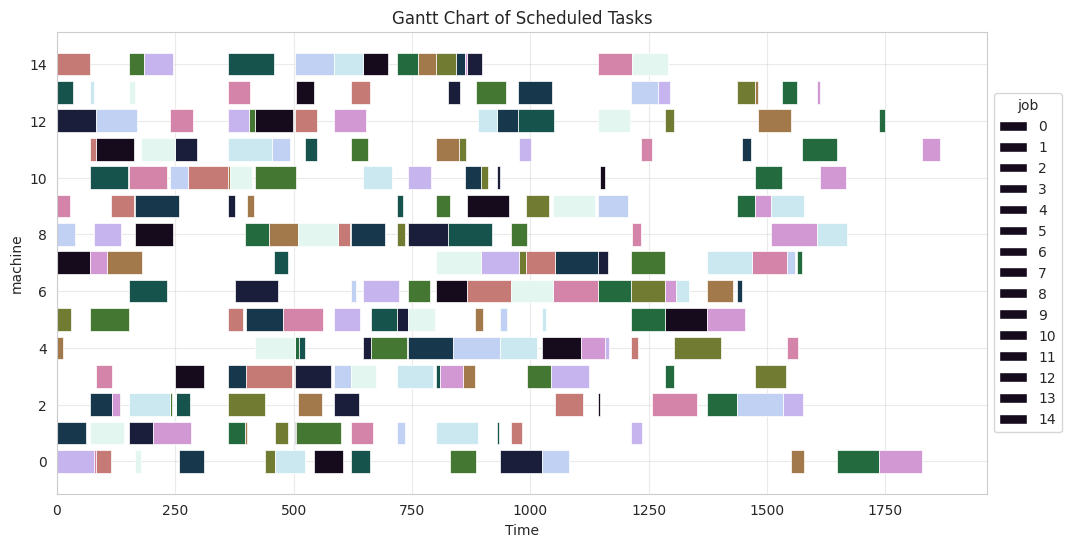

In [20]:
taillard_envs.render()

In [16]:
makespans

[1231,
 1244,
 1218,
 1175,
 1224,
 1238,
 1227,
 1217,
 1274,
 1241,
 1357,
 1367,
 1342,
 1345,
 1339,
 1360,
 1462,
 1396,
 1332,
 1348,
 1642,
 1600,
 1557,
 1644,
 1595,
 1645,
 1680,
 1603,
 1625,
 1584,
 1764,
 1784,
 1791,
 1828,
 2007,
 1819,
 1771,
 1673,
 1795,
 1670,
 2006,
 1939,
 1846,
 1979,
 2000,
 2006,
 1889,
 1937,
 1960,
 1923,
 2760,
 2756,
 2717,
 2839,
 2679,
 2781,
 2943,
 2885,
 2655,
 2723,
 2868,
 2869,
 2755,
 2702,
 2725,
 2845,
 2825,
 2784,
 3071,
 2995,
 5464,
 5181,
 5568,
 5339,
 5392,
 5342,
 5436,
 5394,
 5358,
 5183]

In [ ]:
[(val - optimal) / optimal for val, optimal in zip(val_makespans, makespans)]